In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.util as util
import sim_lib.graph_networkx as gnx
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 20

# Simul + some vis parameters
num_iters = 50
add_to_iter = 0
show_last = 3
show_every = 5
log_last = 0
log_every = 0

params = {
    'context_count' : 8,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.max_inv_frequency,
    'edge_proposal' : attr_util.const_one,
    'vtx_util' : attr_util.logistic,
    'edge_selection' : attr_util.seq_projection_edge_edit,
    'attr_copy' : attr_util.freq_attr_copy,
    'seed_type' : 'erdos_renyi', # Type of seed network
    'max_clique_size' : 10,
    'vtx_types' :
        {
            'wide' : { 'likelihood' : 1.0,
                      'struct_util' : attr_util.ball2_size,
                      'color' : 'blue' },
            'tall' : { 'likelihood' : 0.0,
                      'struct_util' : attr_util.potential_density,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def graph_density(G_nxc):
    denum = (len(G_nxc.nodes) * (len(G_nxc.nodes) - 1))
    num = sum([ G_nxc.degree[v] for v in G_nxc.nodes])
    return num / denum

def second_eigv(G_nx):
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian.toarray(), return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def apl(G_nx):
    return nx.average_shortest_path_length(G_nx)

def diam(G_nx):
    return nx.diameter(G_nx)

def bipartite_check(G_nx):
    return nx.is_bipartite(G_nx)

def modularity(G_nx):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

def total_struct_util(G):
    return sum([ u.data['struct_util'](u, G) for u in G.vertices ])

def average_neighborhood_overlap(G_nxc):
    nbor_overlaps = []
    vertices = list(G_nxc.nodes)
    for u_idx, u in enumerate(vertices):
        for v in vertices[u_idx + 1:]:
            nbor_overlaps.append(len(list(nx.common_neighbors(G_nxc, u, v))))
    return sum(nbor_overlaps) / len(vertices)

def print_metrics(G):
    G_nx = gnx.graph_to_nx(G)
    G_nx_comp_nodes = list(nx.connected_components(G_nx))
    G_nx_largest = G_nx.subgraph(max(G_nx_comp_nodes, key=len))
    G_nx_comps = [ G_nx.subgraph(G_nxc_nodes) for G_nxc_nodes in G_nx_comp_nodes ]
    
    component_sizes = [ len(G_nxc) for G_nxc in G_nx_comps ]
    gd = [ graph_density(G_nxc) for G_nxc in G_nx_comps ]
    avg_pl = apl(G_nx_largest)
    diameter = diam(G_nx_largest)
    eig2 = second_eigv(G_nx_largest)
    tsu = total_struct_util(G)
    is_bp = bipartite_check(G_nx)
    anl = [ average_neighborhood_overlap(G_nxc) for G_nxc in G_nx_comps ]
    
    print(f"""Largest component size: {component_sizes}
graph density: {gd}, \n
average path length: {avg_pl}, \n
diameter: {diameter}, \n
second eigenvalue: {eig2} \n
total structural util: {tsu} \n
is bipartite: {is_bp} \n
avg nbor overlap: {anl}\n""")

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

{'context_count': 8, 'k': 8, 'attr_func': <function discrete_pareto_val at 0x7fece929b1e0>, 'edge_util_func': <function max_inv_frequency at 0x7fece955e620>, 'edge_proposal': <function const_one at 0x7fece955ec80>, 'vtx_util': <function logistic at 0x7fece955ebf8>, 'edge_selection': <function seq_projection_edge_edit at 0x7fece929b048>, 'attr_copy': <function freq_attr_copy at 0x7fece929b2f0>, 'seed_type': 'erdos_renyi', 'max_clique_size': 10, 'vtx_types': {'wide': {'likelihood': 1.0, 'struct_util': <function ball2_size at 0x7fece955ea60>, 'color': 'blue'}, 'tall': {'likelihood': 0.0, 'struct_util': <function direct_util_buffer.<locals>.ut_func_wrapper at 0x7fece955e840>, 'color': 'red'}}, 'direct_cost': 0.08333333333333331, 'indirect_cost': 0.0069444444444444415}
Largest component size: [20]
graph density: [0.21052631578947367], 

average path length: 1.8210526315789475, 

diameter: 3, 

second eigenvalue: (1.44382638396576+0j) 

total structural util: 19.399999999999995 

is bipartit

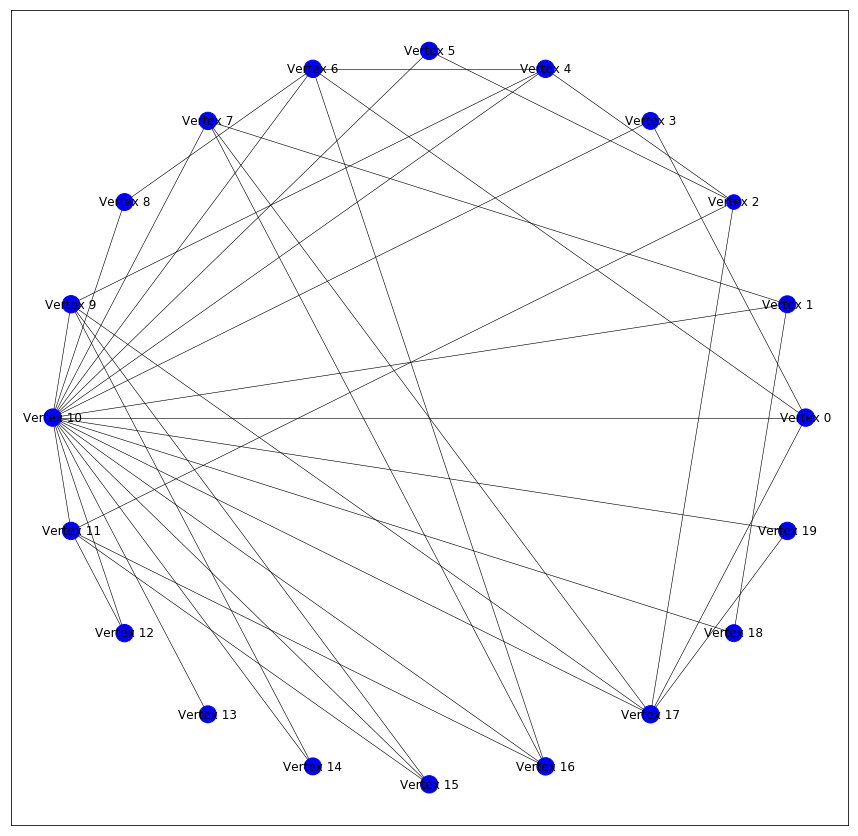

Largest component size: [20]
graph density: [0.24736842105263157], 

average path length: 1.7894736842105263, 

diameter: 3, 

second eigenvalue: (1.3600184047426505+0j) 

total structural util: 19.299999999999997 

is bipartite: False 

avg nbor overlap: [12.05]



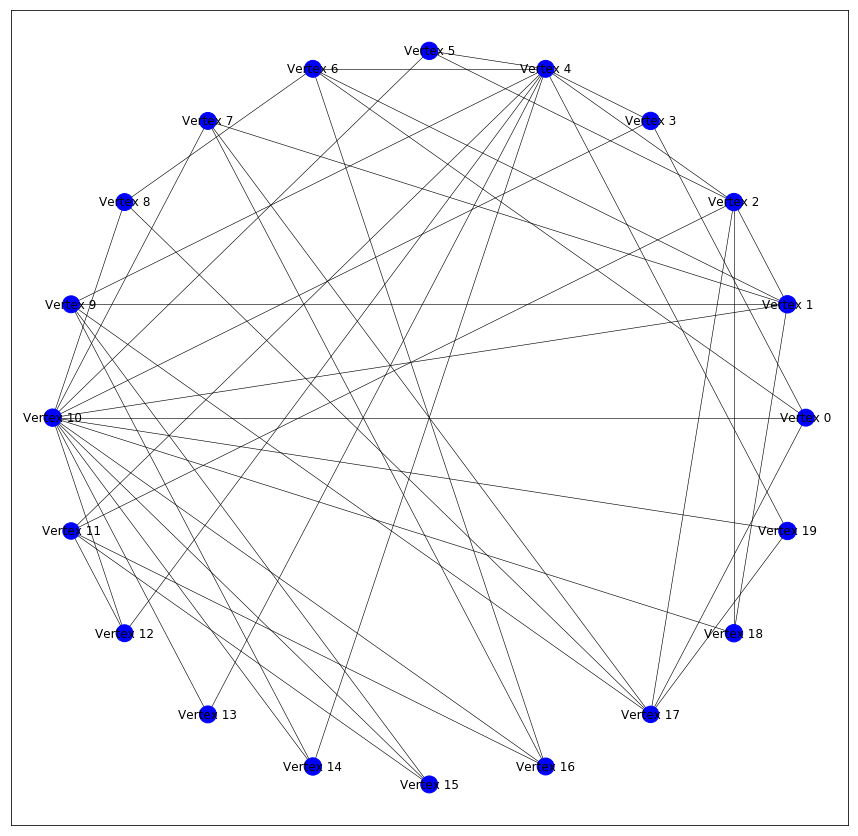

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363593+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



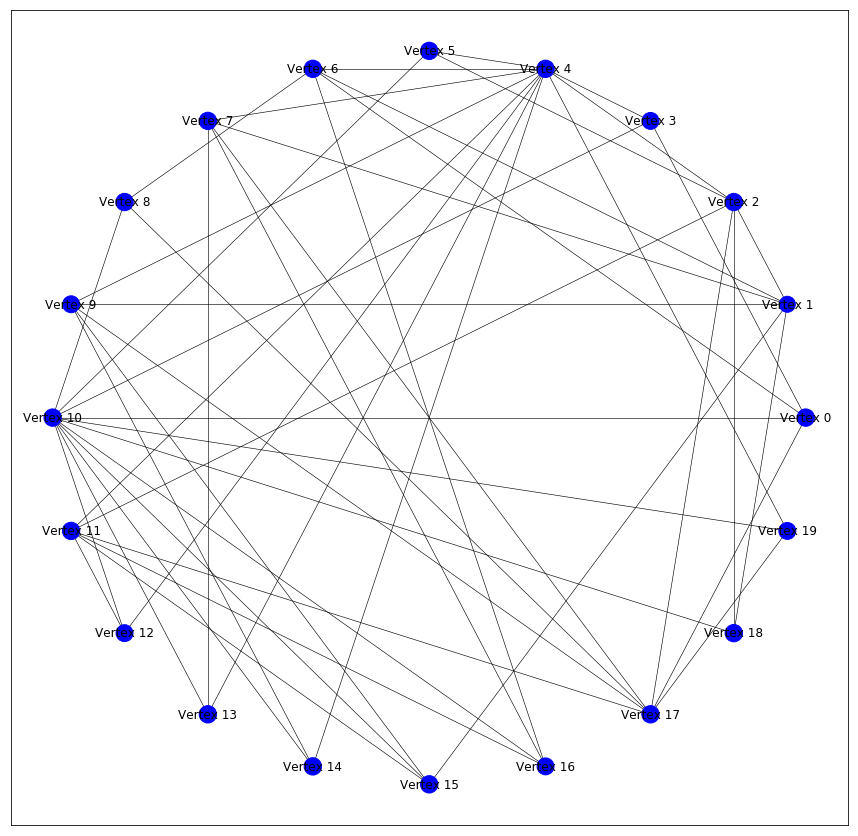

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.388999842936357+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



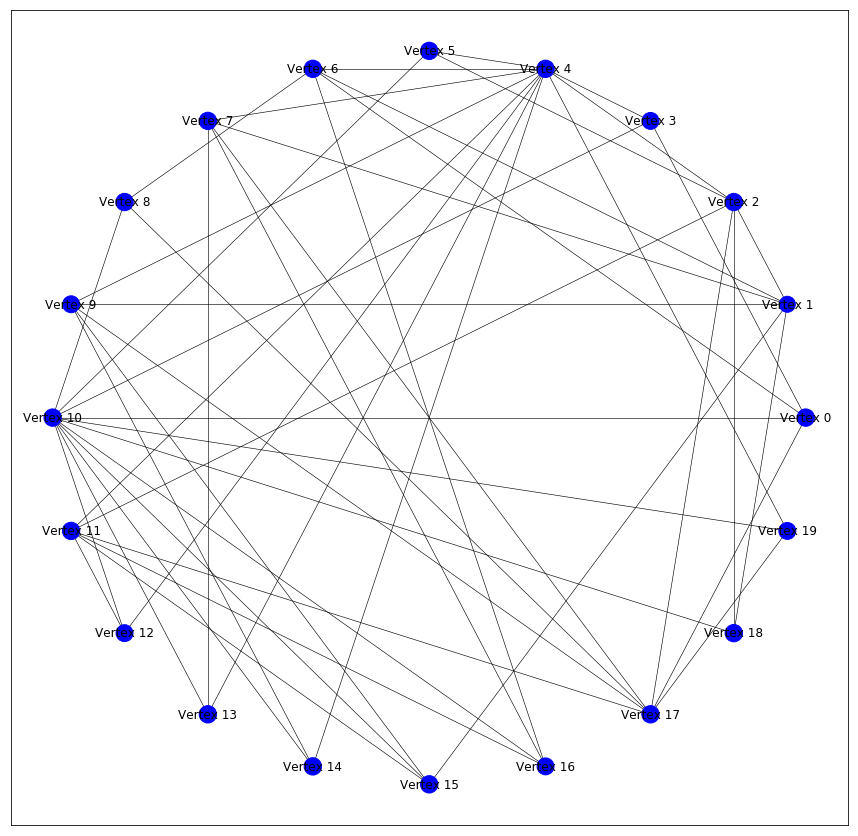

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.38899984293636+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



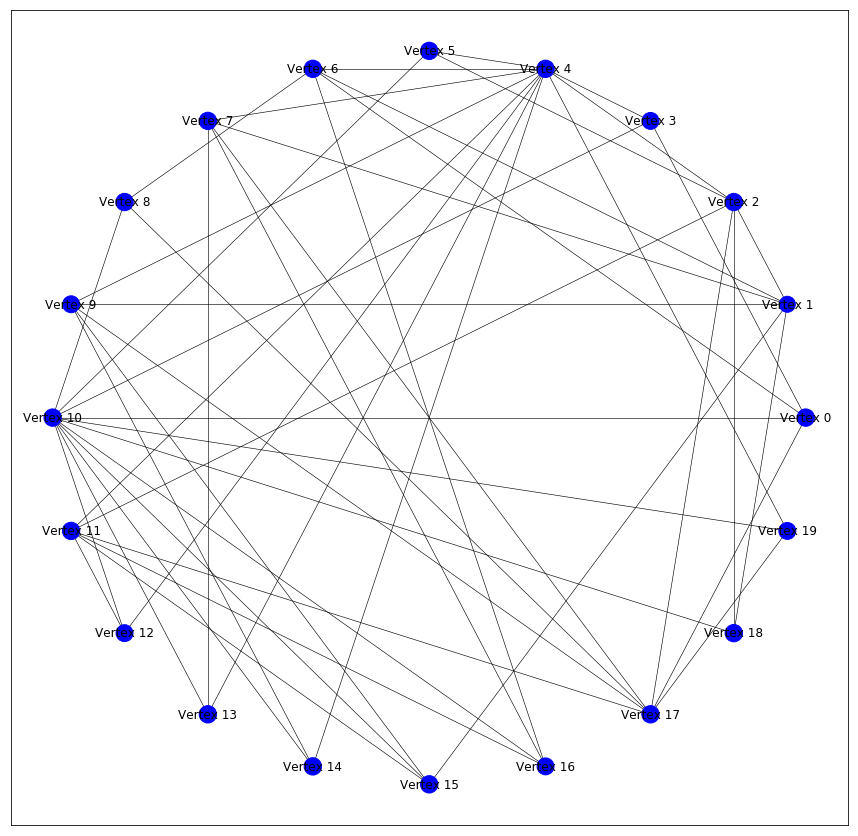

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363628+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



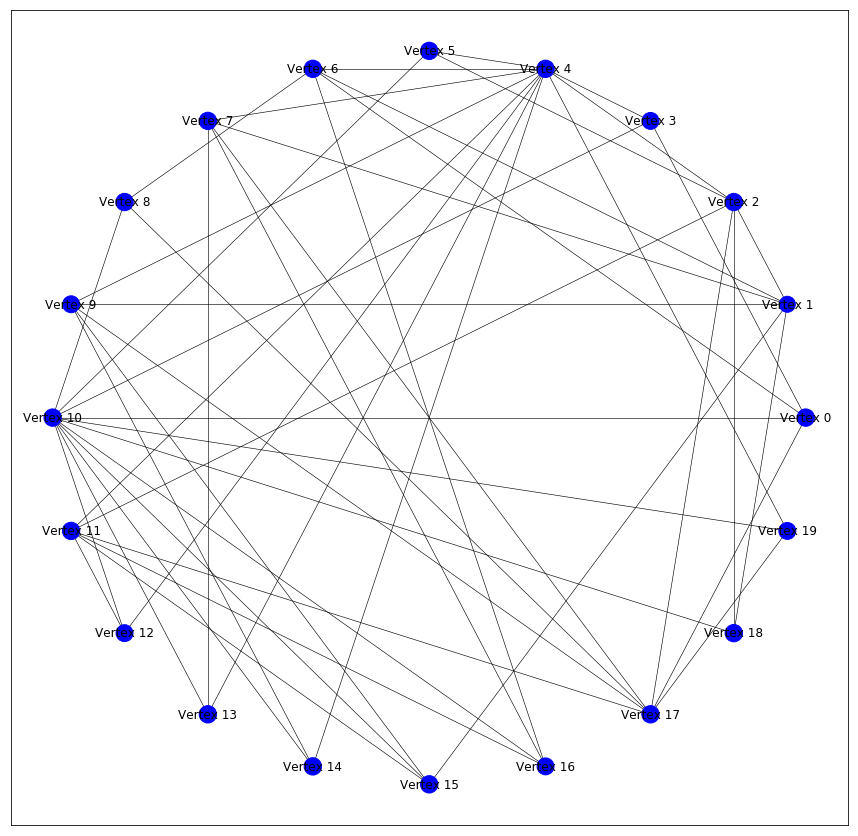

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363597+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



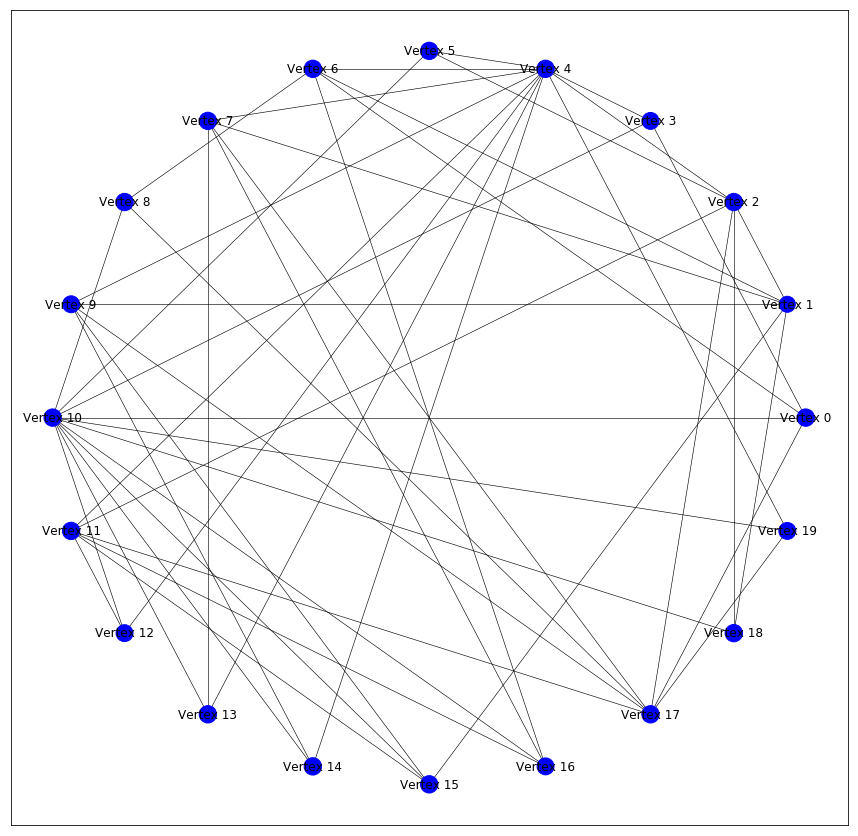

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363646+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



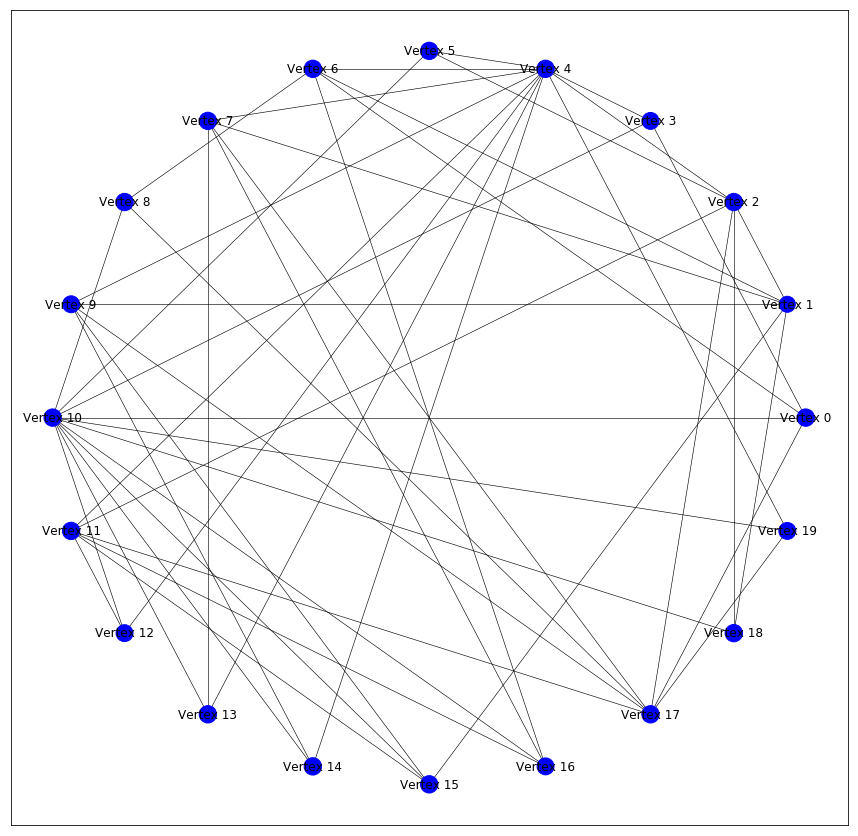

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363573+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



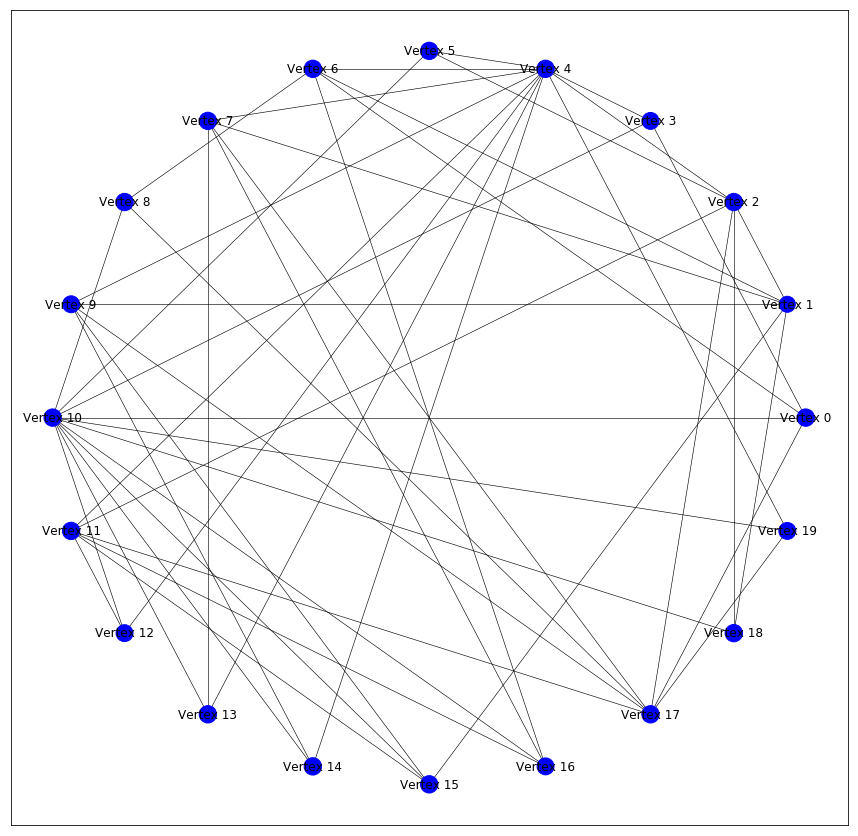

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363632+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



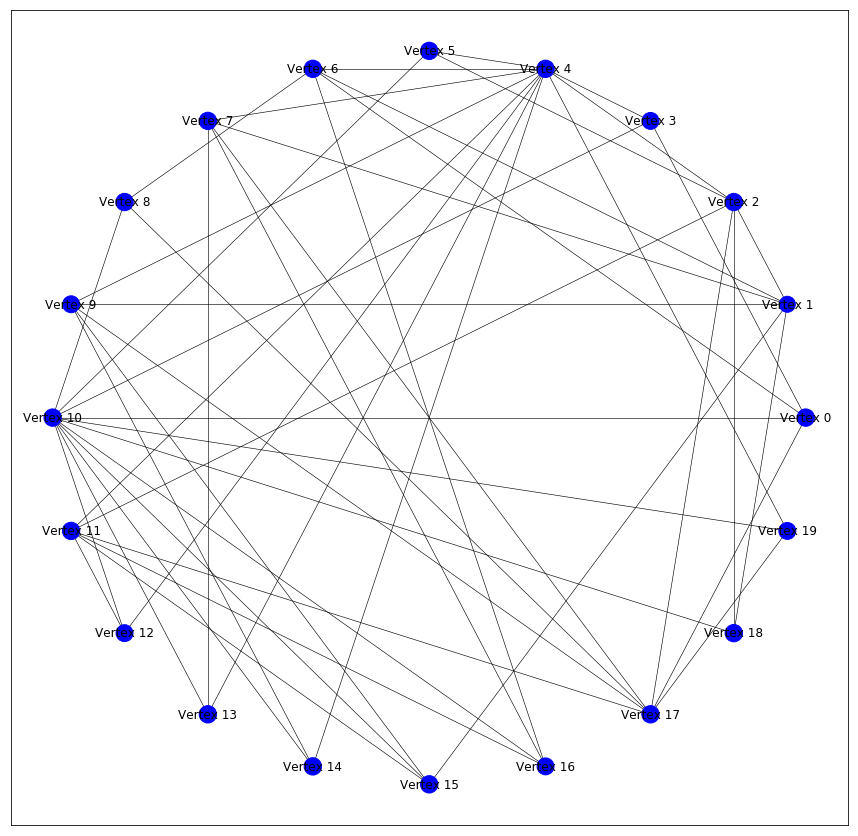

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.388999842936359+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



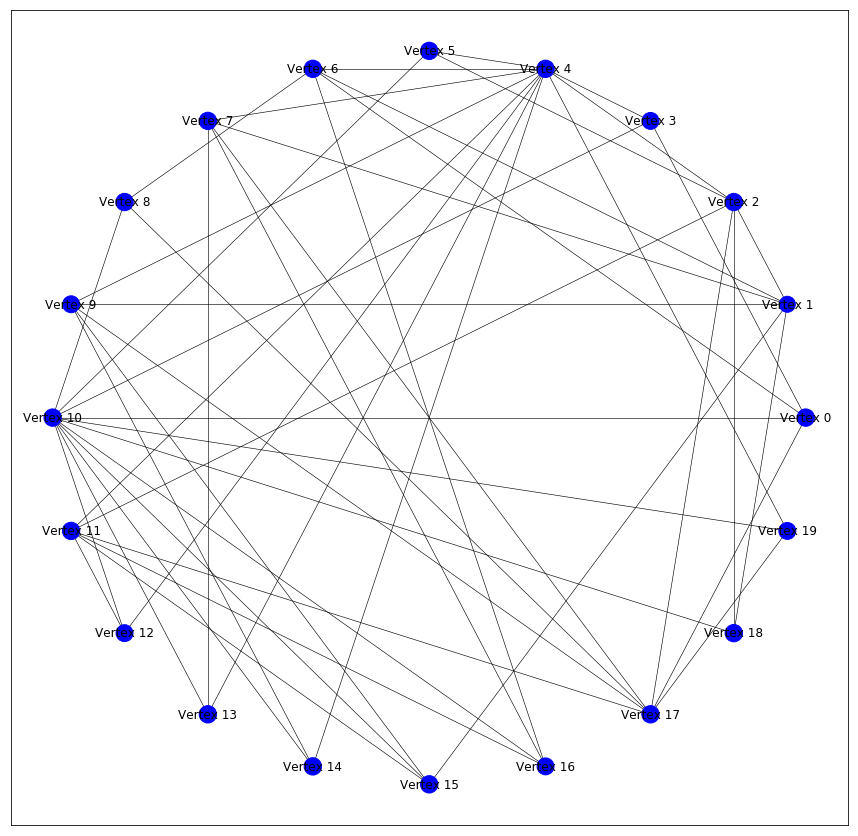

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.388999842936362+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



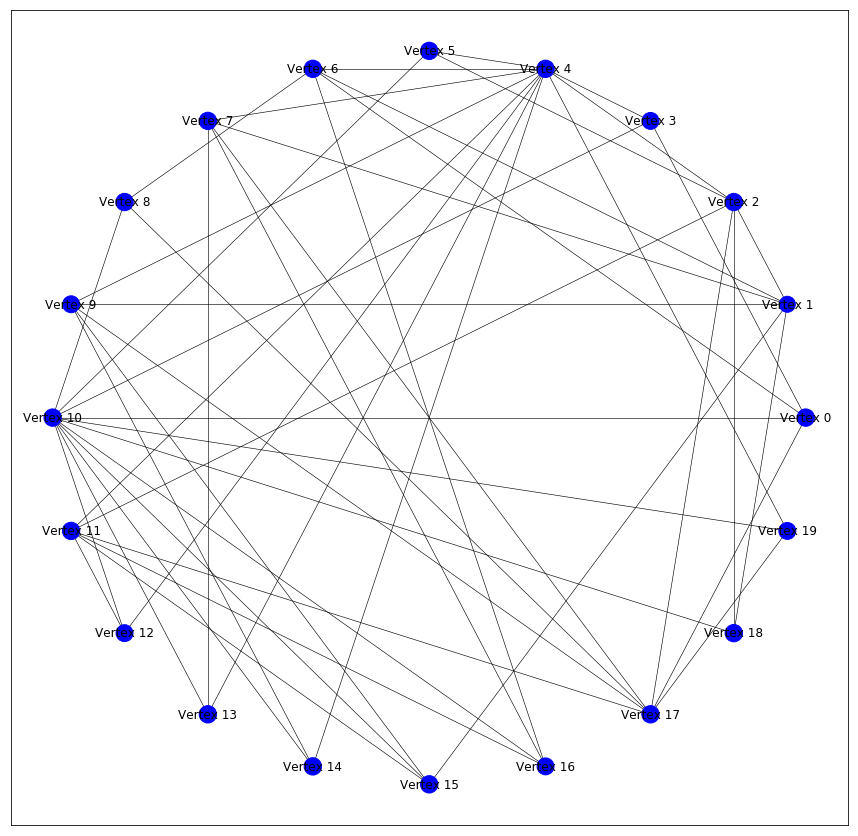

Largest component size: [20]
graph density: [0.2578947368421053], 

average path length: 1.763157894736842, 

diameter: 3, 

second eigenvalue: (1.3889998429363586+0j) 

total structural util: 19.599999999999998 

is bipartite: False 

avg nbor overlap: [12.4]



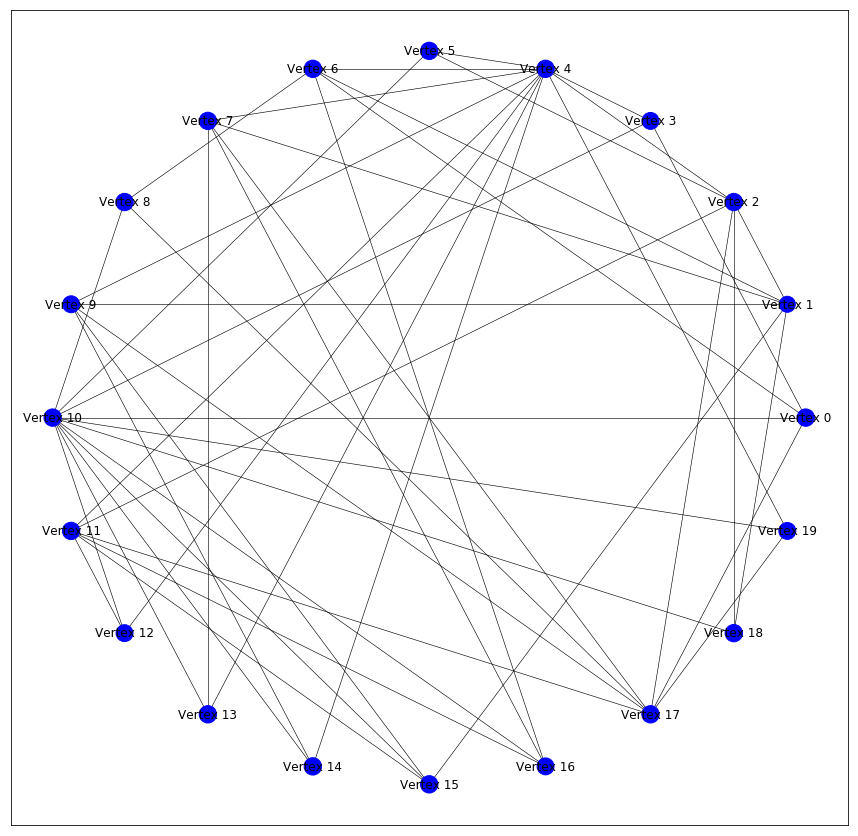

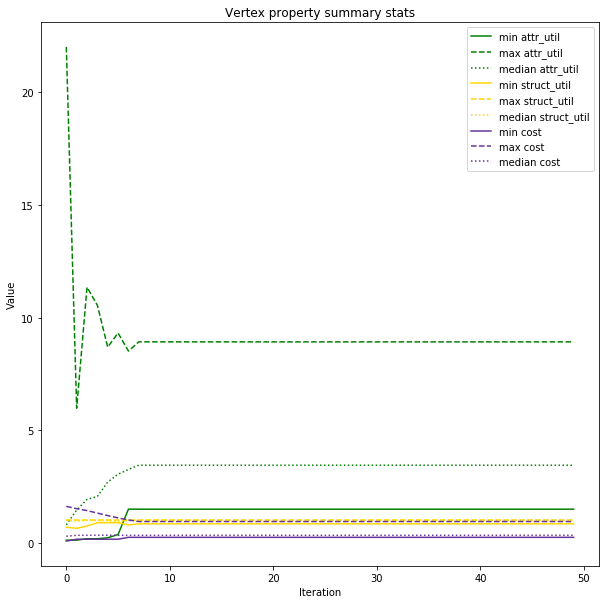

In [5]:
G = attribute_network(_N, params)
print(G.sim_params)

summary_stat_vals = ['attr_util', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

for it in range(num_iters):
    if it < add_to_iter:
        add_attr_graph_vtx(G)
        
    meets_log = (log_every != 0) and ((it % log_every == 0) or (it >= num_iters - log_last))
    if meets_log:
        G.sim_params['edge_selection'] = attr_util.seq_edge_sel_logged
    else:
        G.sim_params['edge_selection'] = attr_util.seq_edge_sel_silent
    
    calc_edges(G)
    simul_random_walk(G)
    for v in [ v for v in G.vertices if v.degree == 0 ]:
        attr_util.indep_context_proposal(G, v)
        
    # Sim iter end, start stat collection
    
    attr_util_vals = [ u.total_edge_util / G.sim_params['edge_util_func'](u, u, G) \
                      for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ attr_util.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
    if it % show_every == 0 or it >= num_iters - show_last:
        
        print_metrics(G)
        vis.draw_graph(G)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Vertex property summary stats")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi],
                 label='{0} {1}'.format(summary_func_names[fi], summary_stat_vals[si]))
plt.legend()
plt.show()